## What's Cooking? Kaggle comp and CDA final project 

#### Description
Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

Acknowledgements: 
We want to thank Yummly for providing this unique dataset. Kaggle is hosting this playground competition for fun and practice.

#### The dataset
In the dataset, we include the recipe id, the type of cuisine, and the list of ingredients of each recipe (of variable length). The data is stored in JSON format. 

## In this notebook: 

1. Set-up
2. EDA
    1. Basic Exploration
    2. Relationship between recipe length and cuisine
    3. Dealing with 1-ingredient recipes
    4. Explorting the most commonly used ingredients
    5. How many and which ingredients can be found in each cuisine
3. Tf-Idf
4. Machine Learning
    1. Balancing the data
    2. Setting up cross-validation and timer
    3. Training the models
        1. Logistic Regression
        2. Multinomial Naive Bayes
        3. Random Forest
        4. Support Vector Machines

# Set-up

In [405]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [409]:
import warnings
warnings.filterwarnings('ignore')

In [410]:
train = pd.read_json('train.json')

In [411]:
train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


This is a 'simple' dataset. We have the label (cuisine), the recipe id (which is for Yummly labelling and offers no real insight into the subject matter), and we have the list of ingredients. 

The focus of this study is on the list of ingredents. We will explore questions including:
* Do some cuisines use more ingredients than others?
* Which cuisines are the most similar? Most different?
* Which ingredients are commonly used across all cuisines?
* Which ingredients provide the best indicator of a recipe's cuisine?

And, of course, we will apply Machine Learning techniques to build a prediction engine that can determine the cuisine of a food based on a list of ingredients.

# EDA

### Basic Exploration

To begin with, we did some basic exploring. We can see that we have about 40,000 recipes in our datase, and that both cuisine and the ingredient lists are currently stored as objects.

In [412]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


There are 20 cuisines. In the below summary we can see that Italian cuisine is 'over-represented' in this dataset, followed closely by Mexican and Southern_US. The dataset is, thus, unbalanced. We will come back to this before we begin ML. For now, it is interesting context for us. 

In [413]:
print(train['cuisine'].value_counts(normalize=True))
print(train['cuisine'].nunique())

italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: cuisine, dtype: float64
20


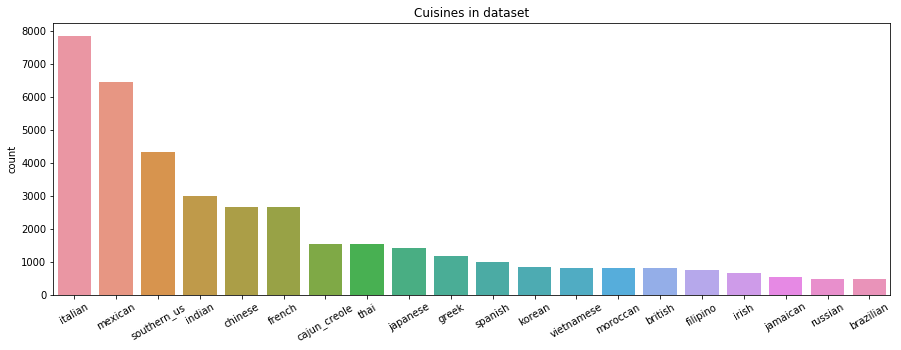

In [414]:
plt.figure(figsize = (15,5))
ax = sns.countplot(train['cuisine'], order = train['cuisine'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('Cuisines in dataset')
ax.set_xlabel('');

### Exploring the relationship between recipe length and cuisine

We created a 'number of ingredients' feature, ie. how many ingredients appear in each recipe. We hypothesise that this may be a contributing factor when predicting cuisine.

In [415]:
train['number'] = [len(i) for i in train['ingredients']]
train.head()

,cuisine,id,ingredients,number
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


In [416]:
train['number'].describe()

count    39774.000000
mean        10.767713
std          4.428978
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: number, dtype: float64

The average recipe length is 11 ingredients. 

In [417]:
print('Maximum Number of Ingredients in a Dish: ',train['number'].max())
print('Minimum Number of Ingredients in a Dish: ',train['number'].min())

Maximum Number of Ingredients in a Dish:  65
Minimum Number of Ingredients in a Dish:  1


The longest recipe has 65 ingredients! The shortest has 1. In the below cell we can see that this longest recipe is in fact Italian. This is likely to be an outlier since Italian food is typically known for being simply, but with high quality and fresh ingredients.

In [418]:
print("Explore the ingredients in the longest recipe in our training set:" + "\n")
print(str(list(train[train['ingredients'].str.len() == 65].ingredients.values)) + "\n")
print("Cuisine: " + str(list(train[train['ingredients'].str.len() == 65].cuisine)))

Explore the ingredients in the longest recipe in our training set:

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'Neufchâtel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pep

Now that we have created a number field , we can begin to explore the relationship between recipe complexity and cuisine. We already know that the longest recipe is Italian, but in the next section we also learn that, on average, the cuisines with the most ingredients are Moroccan (13), Indian (12), Vietanmese (12), Cajun (12) and Thai (12).

Brazilian, British, French, Irish, Japanese and Southern US recipes are typically the shortest. 

In [419]:
# create a dataframe grouped by cuisine to get average number of ingredients by cuisine, and sort

result = train.groupby(["cuisine"])['number'].mean().reset_index().sort_values('number', ascending = False)
result

,cuisine,number
14,moroccan,12.909866
7,indian,12.705961
19,vietnamese,12.675152
2,cajun_creole,12.617076
18,thai,12.545809
10,jamaican,12.214829
3,chinese,11.982791
12,korean,11.284337
13,mexican,10.877446
17,spanish,10.423660


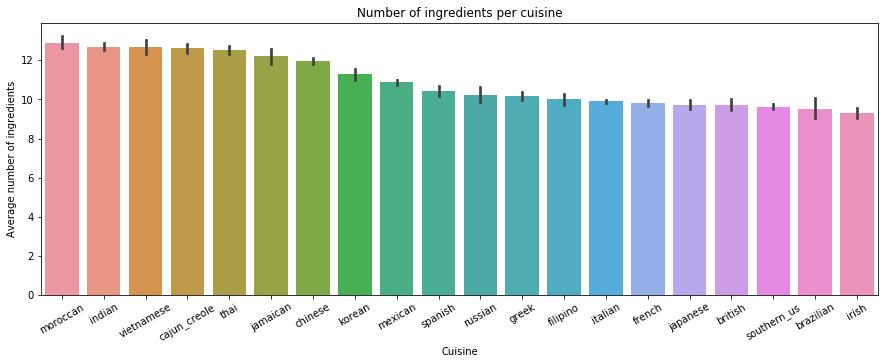

In [420]:
plt.figure(figsize = (15,5))
ax = sns.barplot(x = 'cuisine', y = 'number', data = train, order = result['cuisine'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
ax.set_title('Number of ingredients per cuisine')
ax.set_ylabel('Average number of ingredients')
ax.set_xlabel('Cuisine');


### Dealing with 1-ingredient recipes

We have 22 recipes with only 1 ingredient. These 1-ingredient recipes are more likely to be Indian. A 1-ingredient recipe does not make much sense given the context of our study, and will mislead the algorithm to over-value these ingredients. We therefore discard these rows. 

In [421]:
train[train['number'] < 2]

,cuisine,id,ingredients,number
940,japanese,4734,[sushi rice],1
2088,vietnamese,7833,[dried rice noodles],1
6787,indian,36818,[plain low-fat yogurt],1
7011,indian,19772,[unsalted butter],1
8181,japanese,16116,[udon],1
8852,thai,29738,[sticky rice],1
8990,indian,41124,[butter],1
10506,mexican,32631,[corn tortillas],1
13178,thai,29570,[grained],1
17804,southern_us,29849,[lemonade concentrate],1


In [422]:
train[train['number'] < 2].shape

(22, 4)

In [423]:
train[train['number'] < 2].groupby('cuisine')['cuisine'].count()

cuisine
french         2
greek          1
indian         6
italian        1
japanese       3
mexican        2
southern_us    1
spanish        2
thai           3
vietnamese     1
Name: cuisine, dtype: int64

In [424]:
# removing 1-ingredient recipes leaves us with 39,752 observations

train = train[train['number'] > 1]
train.shape

(39752, 4)

### Exploring the most commonly used ingredients

Now we begin to look at the counts of different ingredients to understand which are most commonly used. Here we have to create a list storing all of the unique ingredients in our dataframe with duplicates, and then cast to a dataframe by grouping by ingredient and counting how many times each ingredient occurs. 

In [425]:
allingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in train['ingredients']:
    for ingr in item:
        allingredients.append(ingr) 

In [426]:
# converting to a dataframe 
ingredients_df = pd.DataFrame(allingredients, columns=['ingredient'])

In [427]:
# counting number of recipes with each ingredient
ingredients_df = ingredients_df.groupby('ingredient')['ingredient'].count().reset_index(name="count")
ingredients_df.head()

,ingredient,count
0,( oz.) tomato sauce,11
1,( oz.) tomato paste,9
2,(10 oz.) frozen chopped spinach,3
3,"(10 oz.) frozen chopped spinach, thawed and sq...",2
4,(14 oz.) sweetened condensed milk,2


In [428]:
# checking the modet commonly used 20 ingredients

print("The most commonly used ingredients (with counts) are:")
print("\n")
print(ingredients_df.nlargest(20, 'count'))
print("\n")
print("The number of unique ingredients in our training sample is: ", ingredients_df['ingredient'].nunique())

The most commonly used ingredients (with counts) are:


               ingredient  count
5309                 salt  18049
4343            olive oil   7972
4361               onions   7972
6435                water   7456
2884               garlic   7380
5888                sugar   6434
2890        garlic cloves   6237
1220               butter   4846
3135  ground black pepper   4785
555     all-purpose flour   4632
4569               pepper   4438
6375        vegetable oil   4384
2436                 eggs   3388
5744            soy sauce   3296
3591          kosher salt   3113
3102         green onions   3078
6146             tomatoes   3058
3641           large eggs   2948
1386              carrots   2814
6268      unsalted butter   2779


The number of unique ingredients in our training sample is:  6714


There are 6714 unique ingredients in our sample, and the most commonly used ingredients are salt, olive oil, onions and water. This is not suprising since these ingredients are flavour enhancers used across the globe. It is highly likely that these, along with the other most commonly used ingredients will have poor predictive power (we explore this in greater detail later using tf-idf).

In [429]:
# checking the ingredients that only occur in one recipe

print("Ingredients that only occur in 1 recipe are:")
print("\n")
print(ingredients_df[ingredients_df['count'] == 1])

Ingredients that only occur in 1 recipe are:


                                             ingredient  count
12                             2% low fat cheddar chees      1
15                   2% milk shredded mozzarella cheese      1
18                      33% less sodium cooked deli ham      1
19                           33% less sodium cooked ham      1
21              33% less sodium smoked fully cooked ham      1
25                    8 ounc ziti pasta, cook and drain      1
27                         A Taste of Thai Rice Noodles      1
29                          Adobo All Purpose Seasoning      1
31                                  Alexia Waffle Fries      1
33                                     Amarena cherries      1
38                                     Argo Corn Starch      1
40                              Asian sweet chili sauce      1
41                               Azteca Flour Tortillas      1
42                        BACARDI® Mixers Margarita Mix      1
43      

A large number of ingredients (1759) only appear in one recipe. This is partly because they are very specific ingredients, and many include brand names. We will not try to harmonize these now. These ingredients are likely to have stronger predictive power when predicting cuisine. 

### How many and which ingredients can be found in each cuisine

Now we would like to learn more about the variety of ingredients used in different cuisines. Some questions we want to answer:
* Do Indian recipes typically call for the same set of spices? 
* Does the lower number of ingredients per recipe for Japanese cuisine mean that there are fewer ingredients used in Japanese cooking overall?
* Does fewer recipes mean fewer ingredients? Will Italian cuisine have the most ingredients because we also have the highest number of recipes in our sample?

In [430]:
# Define a function that returns how many different ingredients can be found in all recipes for a given cuisine

def findnumingr(cuisine):
    listofinrg = []
    for item in train[train['cuisine'] == cuisine]['ingredients']:
        for ingr in item:
            listofinrg.append(ingr)
    result = (cuisine,len(list(set(listofinrg))))         
    return result 

In [431]:
# Iterate over each cuisine and add cuisines + total ingredients used to our list

cuisineallingr = []
for cuisine in train['cuisine'].unique():
    cuisineallingr.append(findnumingr(cuisine))

In [432]:
cuisineallingr.sort(key=lambda x: x[1])
cuisineallingr

[('brazilian', 853),
 ('russian', 872),
 ('jamaican', 877),
 ('korean', 898),
 ('filipino', 947),
 ('moroccan', 974),
 ('irish', 999),
 ('vietnamese', 1108),
 ('british', 1166),
 ('greek', 1198),
 ('spanish', 1263),
 ('thai', 1375),
 ('japanese', 1439),
 ('cajun_creole', 1576),
 ('indian', 1664),
 ('chinese', 1792),
 ('french', 2102),
 ('southern_us', 2462),
 ('mexican', 2684),
 ('italian', 2929)]

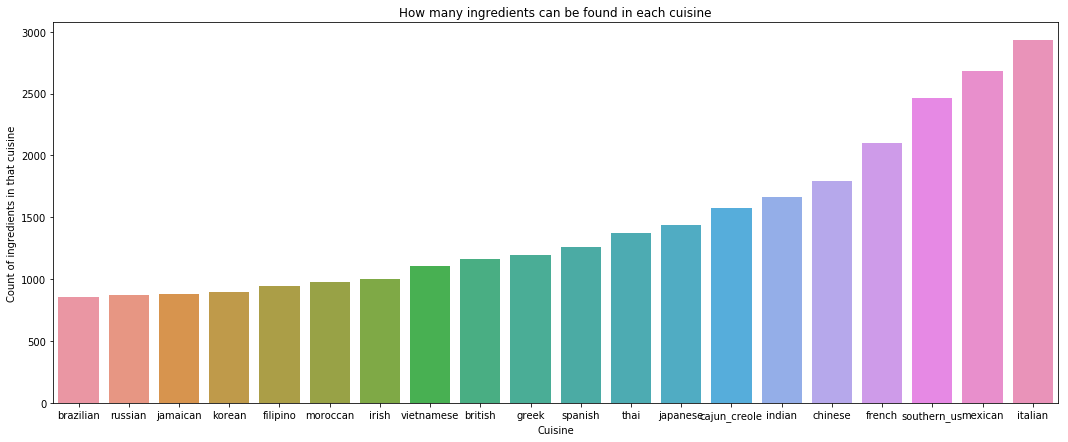

In [433]:
plt.figure(figsize=(18, 7))
sns.barplot(y = [i[1] for i in cuisineallingr], 
           x = [i[0] for i in cuisineallingr],
           order = cuisineallingr.sort(key=lambda x: x[1], reverse = False))
plt.xlabel('Cuisine')
plt.ylabel('Count of ingredients in that cuisine')
plt.title('How many ingredients can be found in each cuisine');

From the above bar chart, we can see that cuisines with more recipes in the training set do not always have more ingredients representing them.  For example, French cuisine is only 6.65% of he training set, but has more variability than Indian cuisine (which makes up 7.5%). 

As expected, however, Italian cuisine has the greatest range of ingredients. This is likely because we have such a large number of Italian recipes in our sample.

Now, we explore which ingredients are specific only to ONE cuisine (and will therefore have strong predictive power.)

In [434]:
# We used allingredients before (it's a list of all ingredients in the training sample, with duplication)
# Now we remove duplicates
allingredients = list(set(allingredients))

In [435]:
# Define a function that returns a dataframe with top 5 unique ingredients in a given cuisine 
def cuisine_unique(cuisine, allingredients):
    allother = []
    
    # create a list of ingredients that appear in other cuisines
    for item in train[train['cuisine'] != cuisine]['ingredients']:
        for ingr in item:
            allother.append(ingr)
    allother  = list(set(allother ))
    
    # compare allother to the full list in allingredients, and only keep ingredients that aren't in allother
    specificnonly = [x for x in allingredients if x not in allother]
    
    mycounter = Counter()
    
    # for every ingredient that appears in that cuisine, find number of associated recipes in that cuisine
    for item in train[train['cuisine'] == cuisine]['ingredients']:
        for ingr in item:
            mycounter[ingr] += 1
    keep = list(specificnonly)
    
    # only keep the recipe counts if that ingredient is unique to the cuisine
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    # create a dataframe that shows the recipe count for each ingredient unique to the cuisine
    cuisinespec = pd.DataFrame(mycounter.most_common(5), columns = ['ingredient','count'])
    cuisinespec['Cuisine'] = cuisine
    
    return cuisinespec

In [436]:
cuisine_unique('italian', allingredients)

,ingredient,count,Cuisine
0,gnocchi,41,italian
1,"lasagna noodles, cooked and drained",26,italian
2,bulk italian sausag,21,italian
3,potato gnocchi,20,italian
4,cheese ravioli,18,italian


So here we can see that gnocchi is the most unique ingredient to Italian cuisine. It appears in no other cuisines, but in 41 Italian recipes. This is followed by lasagne noodles. 

In [437]:
# Now create a new dataframe with all of this information

unique_ing = pd.DataFrame()

for i in train['cuisine'].unique():
    unique_ing = unique_ing.append(cuisine_unique(i, allingredients))

In [438]:
unique_ing

,ingredient,count,Cuisine
0,ouzo,10,greek
1,kefalotyri,9,greek
2,greek-style vinaigrette,5,greek
3,pita loaves,5,greek
4,sliced kalamata olives,4,greek
0,collards,14,southern_us
1,buttermilk biscuits,12,southern_us
2,Nilla Wafers,10,southern_us
3,grit quick,8,southern_us
4,peaches in heavy syrup,6,southern_us


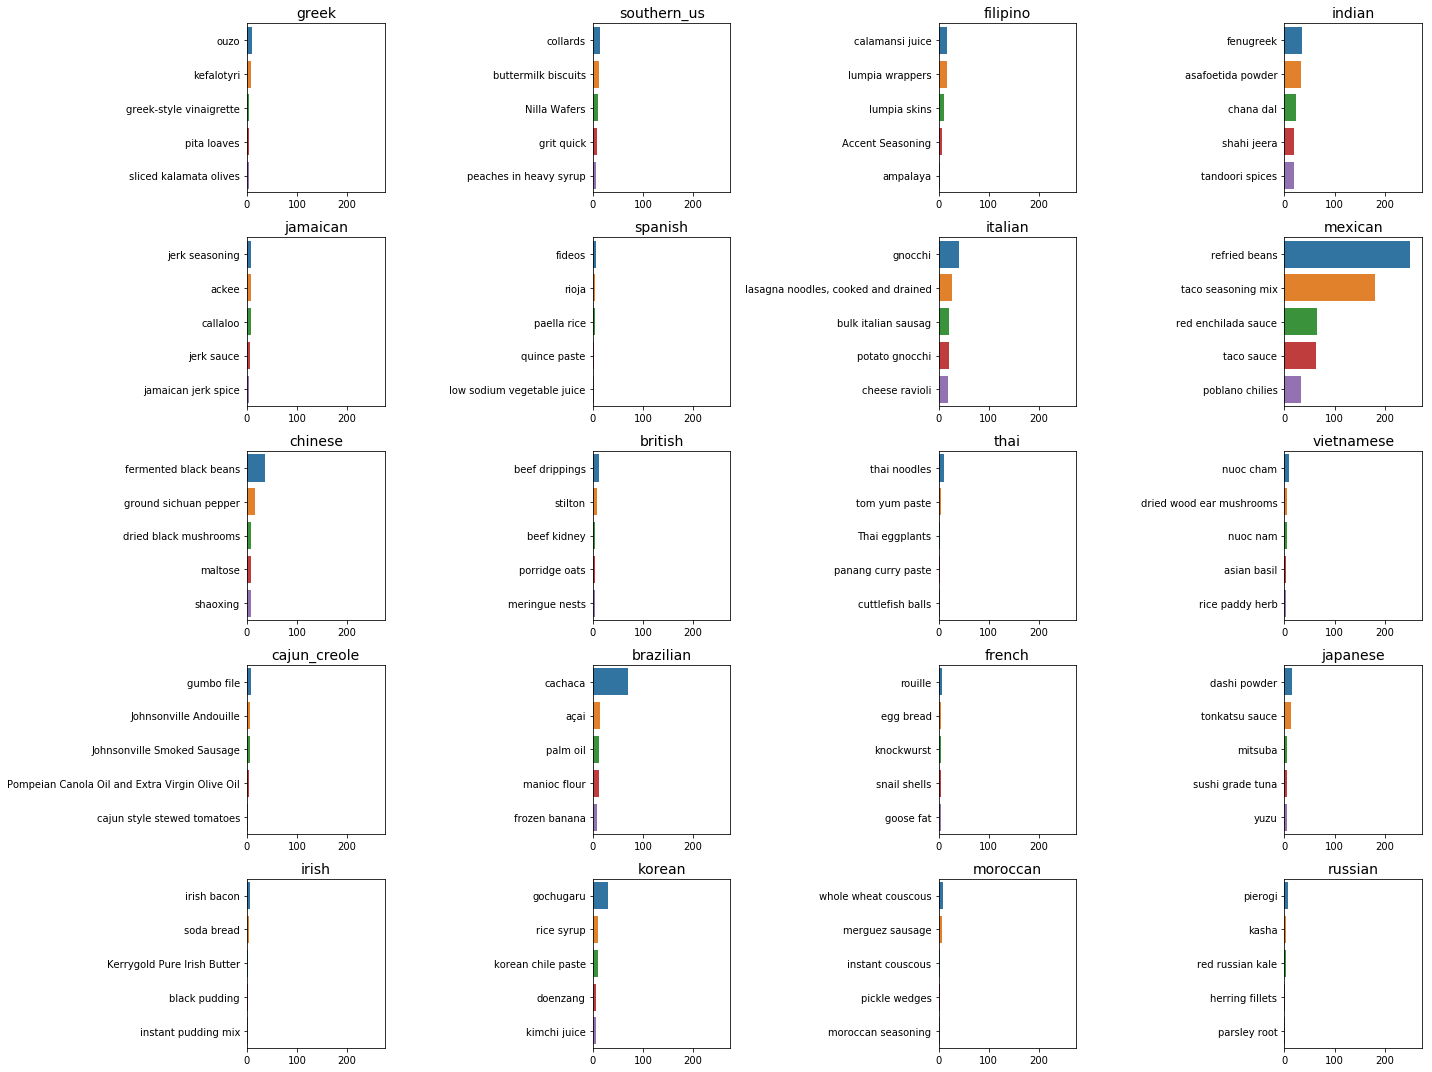

In [439]:
# plotting with each cuisine on the same xlim

fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, unique_ing['Cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'count', 
                data = unique_ing[unique_ing['Cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0, 275)

plt.tight_layout()
#plt.title('Unique ingredients per cuisine');

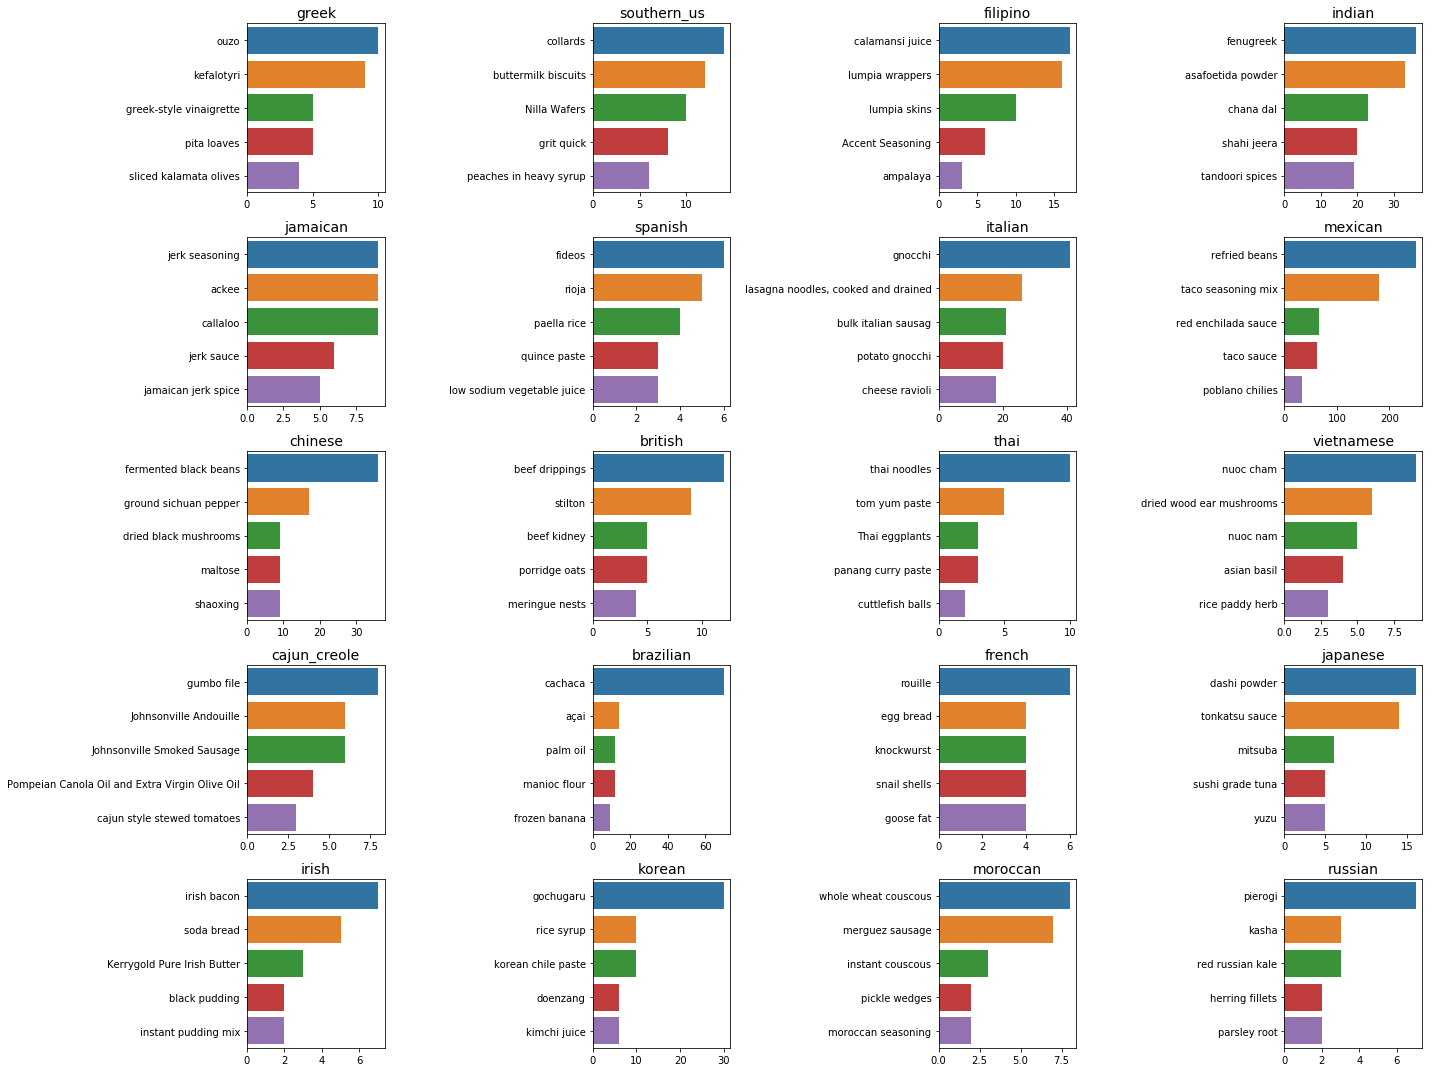

In [440]:
# And then again without forcing the xlim

fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, unique_ing['Cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'count', 
                data = unique_ing[unique_ing['Cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.tight_layout()
#plt.title('Unique ingredients per cuisine');

The above plots show us quite a bit about how differentiated the cuisines are, and give us an indication of how easy/hard it will be to predict a cuisine based on its ingredients. 

* Mexican cuisine is the only one where the unique ingredients (mainly refried beans) are also highly represented across Mexican recipes; refried beans are found in more than 200 Mexican recipes in our dataset. We can expect that refried beans and taco seasoning will play an important role in predicting whether a cuisine is Mexican. 
* Cachaca is the next most important predictor for a cuisine, with more than 60 Brazilian recipes calling for this spirit
* Gnocchi is an important unique ingredient for Italian food (unsuprisingly) 
* Fenugreek is important and unique to Indian food
* Fermented black-beans is important for Chinese cuisine
* Gochugaru is unique to Korean
* The remaining cuisines may be harder to accurately predict based on ingredient presence, they had fewer recipes with ingredients unique to their style of cooking. 

We will drill in to this further using TfIdf, and of course, validate how well our cuisines can be predicted once we begin ML.

# Tf-Idf

Now that we have explored the data and begun to understand some preliminary differences between the cuisines in terms of number of ingredients and key ingredients used, we can apply the tf-idf approach.  This allows us to uncover which ingredients are important to a specific cuisine, within our whole dataset. These will be ingredients that are frequently used in the recipes belonging to that cuisine and at the same time not so frequently used in the whole sample of recipes. 

In our case:
* Corpus = the What's cooking dataset
* Document = recipe
* Word = ingredient

Note that we are using the data as is - we have removed 1-ingredient recipes, and converting to lowercase, but that is the only cleaning. 

In [441]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [442]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [443]:
# list of all the recipes

features = [] 
for item in train['ingredients']:
    features.append(item)
len(features)

39752

In [444]:
# this is our vocabulary; all ingredients from all recipes (with duplicates)

ingredients = [] 
for item in train['ingredients']:
    for ingr in item:
        ingredients.append(ingr) 
len(ingredients)

428253

#### Further preparing the data

We need to transform our ingredients such that they are in a cleaner format. We will do some final transformations on the data here, including: 
* converting all words to lower case;
* removing punctuation and special characters
* removing units of measurement to remove noise 


In [677]:
# Reminder of our features variable

features

[['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles'],
 ['plain flour',
  'ground pepper',
  'salt',
  'tomatoes',
  'ground black pepper',
  'thyme',
  'eggs',
  'green tomatoes',
  'yellow corn meal',
  'milk',
  'vegetable oil'],
 ['eggs',
  'pepper',
  'salt',
  'mayonaise',
  'cooking oil',
  'green chilies',
  'grilled chicken breasts',
  'garlic powder',
  'yellow onion',
  'soy sauce',
  'butter',
  'chicken livers'],
 ['water', 'vegetable oil', 'wheat', 'salt'],
 ['black pepper',
  'shallots',
  'cornflour',
  'cayenne pepper',
  'onions',
  'garlic paste',
  'milk',
  'butter',
  'salt',
  'lemon juice',
  'water',
  'chili powder',
  'passata',
  'oil',
  'ground cumin',
  'boneless chicken skinless thigh',
  'garam masala',
  'double cream',
  'natural yogurt',
  'bay leaf'],
 ['plain flour',
  'sugar',
  'butter',
  'eggs',
  'fresh ginger root',
  'salt',
  'ground 

In [678]:
import re

features_processed= [] # here we will store the preprocessed training features
for item in features:
    newitem = []
    for ingr in item:
        ingr.lower() # Case Normalization - convert all to lower case 
        ingr = re.sub("[^a-zA-Z]"," ",ingr) # Remove punctuation, digits or special characters 
        ingr = re.sub((r'\b(oz|ounc|ounce|pound|lb|inch|inches|kg|to)\b'), ' ', ingr) # Remove different units  
        newitem.append(ingr)
    features_processed.append(newitem)

In [679]:
type(features_processed)

list

In [687]:
# Fit the TfidfVectorizer to data

tfidf = TfidfVectorizer(vocabulary= list(set([str(i).lower() for i in ingredients])))
X_tr = tfidf.fit_transform([str(i) for i in features_processed]) # X_tr - matrix of tf-idf scores
feature_names = tfidf.get_feature_names()


# Define the target variable

cuisine = train['cuisine']

In [681]:
# Define a function for finding the most important features in a given cuisine according to Tf-Idf measure 
# We want to look at features only that have a min tfidf of 0.1 (ie. ignore any poor indicators of cuisine)
# We want to return the top 10 most important words/ingredients
# The output is a list of dataframes, one per cuisine, with top  ingredients

def top_feats_by_class(train, target, featurenames, min_tfidf=0.1, top_n=10):

    dfs = pd.DataFrame()
    labels = np.unique(target)
    
    for label in labels: # for each cuisine
        
        ids = np.where(target==label) 
        D = train[ids].toarray() # creates an array of ingredients from our matrix of tfidf scores related to the cuisine
        D[D < min_tfidf] = 0 # keeps only the ingredients that have tfidf greater than 0.1
        tfidf_means = np.nanmean(D, axis=0) # takes the average tfidf for each ingredient 
        
        topn_ids = np.argsort(tfidf_means)[::-1][:top_n] #  Get top n tfidf values
        top_feats = [(featurenames[i], tfidf_means[i]) for i in topn_ids] # find their corresponding feature names
        df = pd.DataFrame(top_feats) # put this all into a df 
        df.columns = ['ingredient', 'tfidf'] # rename for readability
        
        df['cuisine'] = label
        dfs = dfs.append(df)
        
    return dfs

In [682]:
result_tfidf = top_feats_by_class(X_tr, cuisine, feature_names, min_tfidf=0.1, top_n=5)
result_tfidf

,ingredient,tfidf,cuisine
0,milk,0.130959,brazilian
1,lime,0.099823,brazilian
2,cachaca,0.097021,brazilian
3,coconut,0.094198,brazilian
4,pepper,0.081172,brazilian
0,flour,0.130169,british
1,butter,0.116983,british
2,sugar,0.104654,british
3,eggs,0.096452,british
4,milk,0.096065,british


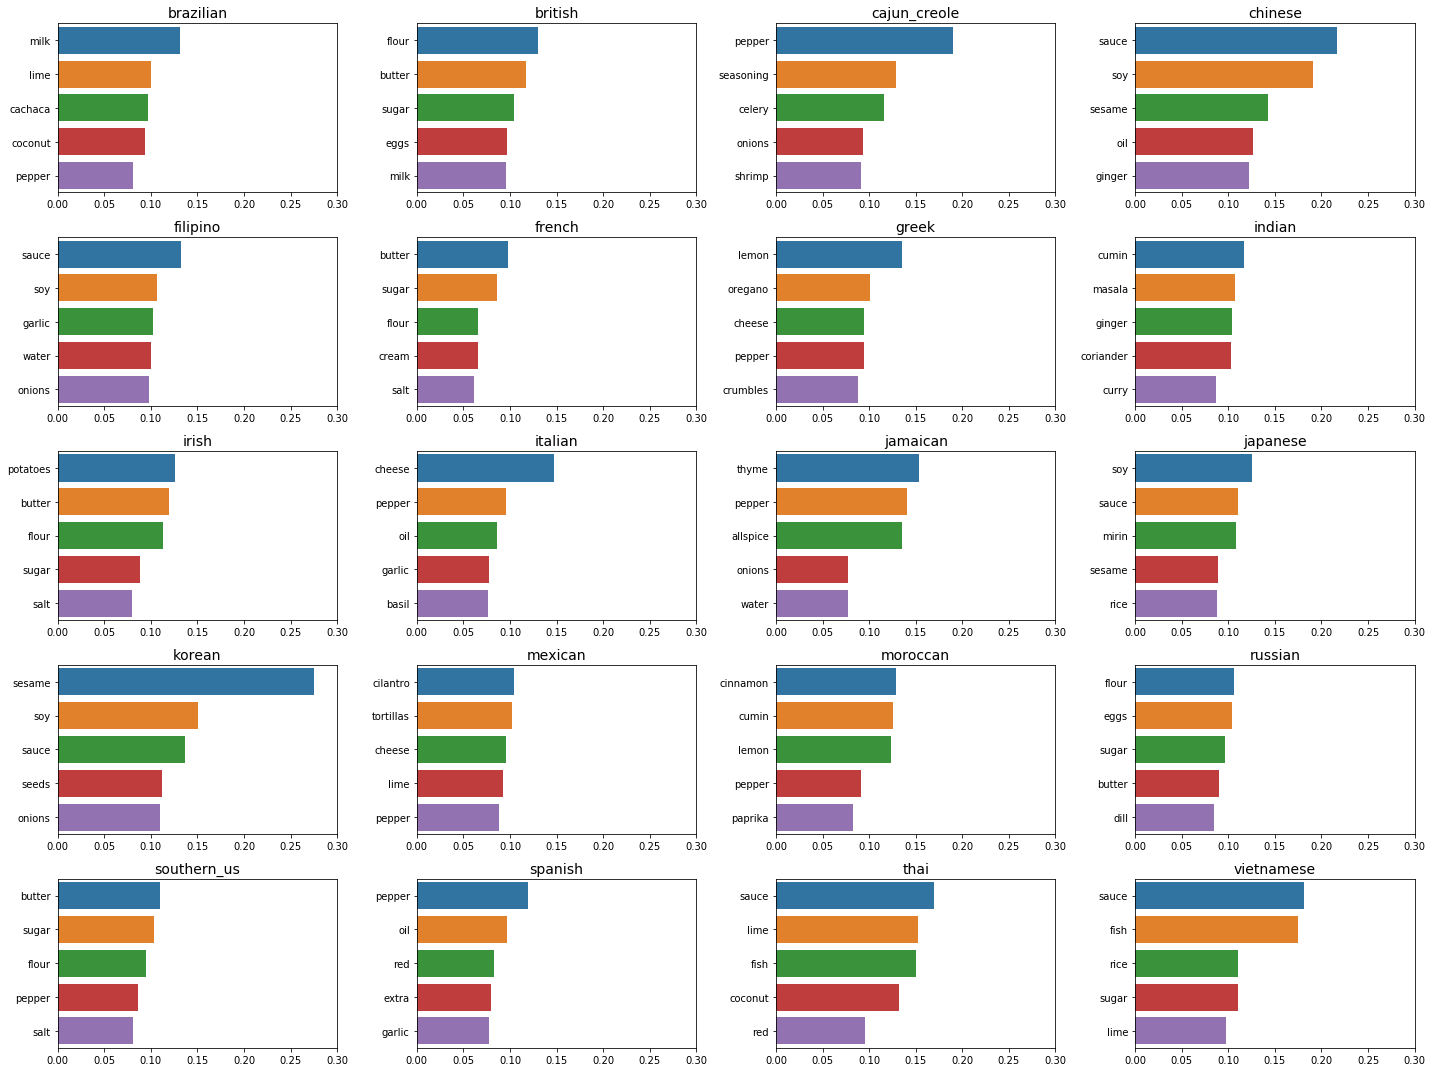

In [683]:
fig, axes = plt.subplots(nrows = 5, ncols = 4,  figsize = (20, 15))
axes = axes.flatten()
for ax, cuisine in zip(axes, result_tfidf['cuisine'].unique()):
    sns.barplot(y = 'ingredient', 
                x = 'tfidf', 
                data = result_tfidf[result_tfidf['cuisine'] == cuisine],
                ax = ax)
    ax.set_title(cuisine, fontdict={'fontsize': 14})
    
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0, .3)

plt.tight_layout();
#plt.title('Ingredient importance based on tfidf');

# This needs to be reviewed

From the vizualizations above we can make the following observations: 

* Some of our assumptions from earlier EDA were correct: 
    * Cachaca is major ingredient in Brazilian recipes
    * Tortillas are important in Mexican cuisine
* Some important words appear in many cuisines:
    * Sauce, fish, soy, sesame have strong tf-idf values in Chinese, Japanese, Vietnames, Thai, Filipino and Korean foods. 
    * Butter flour and sugar are important in both British, French and Irish cuisines.
    * Spanish, Italian and Greek are clearly all Mediterranean cusines, all using a combination of oil, garlic, pepper and cheese.
    * Moroccan, Indian and Jamaican cuisine rely more heavily on spices.

# Machine Learning

Now that we have conducted some in-depth EDA and have a better understanding of the ingredients and cuisines in our data, we are ready to apply some Machine Learning.  We want to build the best model to predict a recipe's cuisine based on the ingredients in the recipe.  

This is a classification challenge. To solve this challenge, we will apply the following ML techniques:
* Logistic Regression
* Naive Bayes
* Random Forest
* Support Vector Machine

More detailed explanation for why we have selected each algorithm is provided in the relevant section.


We will be using the tf-idf matrix as our features when training our models, as prepared earlier. But before we get started with training models, we have a little more preparation:
* Applying a LabelEncoder to our target variable
* Applying truncated SVD to further reduce the size of our data and speed up our model training
* Splitting our data into train and test samples for cross-validation
* Balancing the training data using SMOTE
* Setting up our timer

### Label Encoding the target

In [702]:
# reminder of our tf-idf feature matrix

X_tr.shape

(39752, 6703)

In [688]:
# Now we encode our y labels 

from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y = lb.fit_transform(cuisine)

In [689]:
y.shape

(39752,)

### Dimensionality reduction with Truncated SVD

With our vectorized data, we now have a dataframe with 39752 rows, and 6703 words. This is a very large dataset for our models to train on, and it will be very difficult to run grid searches and pursue our curioisities with this size of a dataset.  We will therefore apply some dimensionaility reduction.  

PCA is the dimensionality reduction technique that we are most familiar with, but it unfortunately does not work with sparse matrices. We will instead apply Truncated SVC. According to scikit learn: 
* this transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.
* In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [693]:
from sklearn.decomposition import TruncatedSVD

In [706]:
tsvd = TruncatedSVD(n_components = 1000)

In [707]:
X_transformed = tsvd.fit_transform(X_tr)

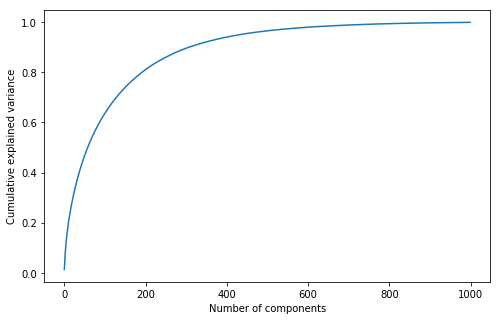

In [708]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

It seems that 1000 components is enough. We could even reduce it to 800, but let's just leave it as 1000 for now.

#### Scaling our data

We plan to use Naive Bayesian modelling, but the TruncatedSVD step produces a matrix with negative values, and we know that MultinomialNB does not accept negative data. This means that we have to re-scale our data to ensure everything is positive. We will use MinMaxScaler() to do this.

In [709]:
from sklearn.preprocessing import MinMaxScaler

In [710]:
scaler = MinMaxScaler() # default is range 0 to 1

In [711]:
X_scaled = scaler.fit_transform(X_transformed)

#### Splitting the data for cross-validation

First, we split our data into a train set and a test set for cross validation. For each model that we train on our train set, we will test the model on our test set to:

1) check the model's accuracy in practice

2) check for overfitting

We are creating this split now, and will hold it constant across the ML model training to ensure comparability across the models that we train.

In [712]:
from sklearn.model_selection import train_test_split

In [720]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

In [721]:
X_train.shape

(26633, 1000)

In [722]:
X_test.shape

(13119, 1000)

#### Balancing our data

##### Note: We originally used SMOTE, but it made our dataset too large to manage and created noise. We will instead use undersampling.

_As we learned during the EDA, the sample data is unbalanced. We have a high percentage of Italian recipes relative to all other cuisines. If we leave the data as is, the models that we train will learn that there is a higher probability of a recipe being Italian, and so its predictions will be biased. These models will likely have very low recall for non-Italian recipes._
_To fix this, we will apply SMOTE, an over-sampling method. It creates synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class. SMOTE does this by selecting similar records and altering that record one column at a time by a random amount within the difference to the neighbouring records._
_Random Forests and SVMs are particularly sensitive to unbalanced data, so it is important that we apply the SMOTE methodology. It will also benefit the Logistic Regression and Naive Bayesian modelling._

In [723]:
# from imblearn.over_sampling import SMOTE
# import scipy

In [724]:
# counts per class before SMOTE

# scipy.stats.itemfreq(y_train)

In [725]:
# smt = SMOTE()
# X_train, y_train = smt.fit_sample(X_train, y_train)

In [726]:
# counts per class after SMOTE

# scipy.stats.itemfreq(y_train)

Now we have a balanced sample with which to train our models. 

#### Undersampling using Cluster Centroids

To avoid losing potentially useful data, we will use the Cluster Centroids technique for undersampling. This method undersamples the majority class by replacing a cluster of majority samples This method finds the clusters of majority class with K-mean algorithms. Then it keeps the cluster centroids of the N clusters as the new majority samples.

In [601]:
from imblearn.under_sampling import ClusterCentroids
import scipy

In [727]:
sampler = ClusterCentroids()
X_train, y_train = sampler.fit_sample(X_train, y_train)

In [728]:
scipy.stats.itemfreq(y_train)

array([[  0, 304],
       [  1, 304],
       [  2, 304],
       [  3, 304],
       [  4, 304],
       [  5, 304],
       [  6, 304],
       [  7, 304],
       [  8, 304],
       [  9, 304],
       [ 10, 304],
       [ 11, 304],
       [ 12, 304],
       [ 13, 304],
       [ 14, 304],
       [ 15, 304],
       [ 16, 304],
       [ 17, 304],
       [ 18, 304],
       [ 19, 304]])

Now we have a balanced sample with which to train our models. 

#### Timeit

We will be using some computationally-heavy approaches, and so we want to time how long each model takes. The timeit library will help us here.

In [547]:
import time
start_time = time.time()

### Logistic Regression

We will begin with Multinomical Logistic Regression because it is arguable the simplest and more intuitive classifier model that we have learnt. 

In [729]:
# import algorithm

from sklearn.linear_model import LogisticRegression
log = LogisticRegression()

In [730]:
# train model

log.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 11027.8 seconds ---


In [731]:
# apply model to test set and get predictions

log_preds = log.predict(X_test)

In [732]:
# import metrics to evaluate our model

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [733]:
# Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
# We will use this function for all of our models 
    
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

CONFUSION MATRIX


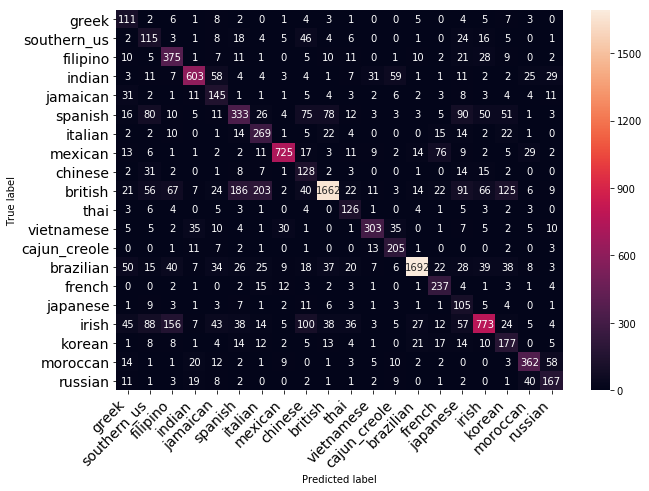

In [734]:
# cross validation
print('CONFUSION MATRIX')
print_confusion_matrix(confusion_matrix(y_test, log_preds), train['cuisine'].unique());

In [735]:
# cross validation
print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, log_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, log_preds))

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

           0       0.33      0.68      0.44       163
           1       0.26      0.44      0.33       259
           2       0.53      0.74      0.62       509
           3       0.82      0.70      0.75       866
           4       0.37      0.58      0.45       248
           5       0.49      0.39      0.43       859
           6       0.45      0.70      0.55       384
           7       0.89      0.77      0.83       940
           8       0.27      0.59      0.37       217
           9       0.88      0.63      0.73      2637
          10       0.45      0.74      0.56       171
          11       0.77      0.66      0.71       462
          12       0.59      0.83      0.69       247
          13       0.94      0.80      0.86      2124
          14       0.57      0.81      0.67       292
          15       0.21      0.62      0.31       168
          16       0.75      0.52      0.62      1480

We can see from the above that our log model has strong precision for Mexican, Italian and Indian food. This makes sense when we remember from our EDA that these cuisines had higher counts of recipes containing ingredients that were totally unique to the cuisine. Recall for Italian food, however, is lower. This also makes sense when we remember that Italian cuisine had the most diverse set of ingredients. 

Overall, this model is not particularly strong. An accuracy score of 66% is below our expectations, so let's keep going!

#### Logistic Regression with Grid Search

Let's try to further improve our logistic regression model by hypertuning the parameters and applying a grid search.

The parameter that we are most interesting in tuning is C, our regularization parameter. We will try a range of C options, from very small (where we increase the regularization strength which will create simpler models that underfit), to very large (where we lower the regularization and increase model complexity). 

In [736]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [737]:
# Specifying the parameters we want to test

C = [0.001,0.01,0.1,1,10,100]

In [738]:
# Building our parameter grid

log_param_grid = {'C': C}

In [739]:
# Running the Grid Search, prioritising accuracy

log_grid_search = GridSearchCV(LogisticRegression(), param_grid=log_param_grid, scoring="accuracy")

In [740]:
log2 = log_grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 11257.89 seconds ---


In [742]:
print(log2.best_score_)
print(log2.best_params_)

0.6098684210526316
{'C': 1}


In [743]:
log_best = LogisticRegression(C = 1)

In [744]:
log_best.fit(X_train,y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 11320.69 seconds ---


In [745]:
log_best_preds = log_best.predict(X_test)

CONFUSION MATRIX


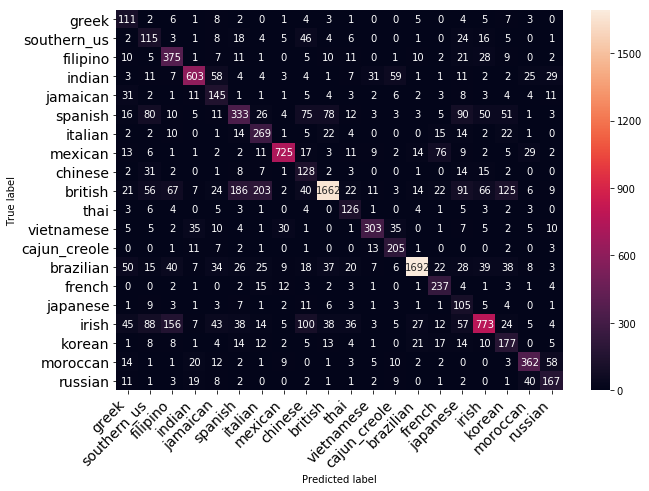

In [746]:
# cross validation
print('CONFUSION MATRIX')
print_confusion_matrix(confusion_matrix(y_test, log_best_preds), train['cuisine'].unique());

In [747]:
print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, log_best_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, log_best_preds))

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

           0       0.33      0.68      0.44       163
           1       0.26      0.44      0.33       259
           2       0.53      0.74      0.62       509
           3       0.82      0.70      0.75       866
           4       0.37      0.58      0.45       248
           5       0.49      0.39      0.43       859
           6       0.45      0.70      0.55       384
           7       0.89      0.77      0.83       940
           8       0.27      0.59      0.37       217
           9       0.88      0.63      0.73      2637
          10       0.45      0.74      0.56       171
          11       0.77      0.66      0.71       462
          12       0.59      0.83      0.69       247
          13       0.94      0.80      0.86      2124
          14       0.57      0.81      0.67       292
          15       0.21      0.62      0.31       168
          16       0.75      0.52      0.62      1480

In [797]:
# EVALUATE THE ABOVE

### Naive Bayes

The next model we are going to apply is Multinomial Naive Bayes. This model is particularly good at predicting categories from text and handling vectorized (sparse) data, so we have high hopes! 

First, let's check out our prior probabilities for the cuisines: 

In [748]:
print(train['cuisine'].value_counts(normalize=True))

italian         0.197147
mexican         0.161904
southern_us     0.108649
indian          0.075392
chinese         0.067242
french          0.066512
cajun_creole    0.038891
thai            0.038640
japanese        0.035721
greek           0.029533
spanish         0.024829
korean          0.020879
vietnamese      0.020729
moroccan        0.020653
british         0.020225
filipino        0.018993
irish           0.016779
jamaican        0.013232
russian         0.012301
brazilian       0.011748
Name: cuisine, dtype: float64


In [749]:
# import algorithm

from sklearn.naive_bayes import MultinomialNB
mn = MultinomialNB()

In [750]:
# train model

mn.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 13707.17 seconds ---


In [751]:
# apply model to test set and get predictions

mn_preds = mn.predict(X_test)

CONFUSION MATRIX: 


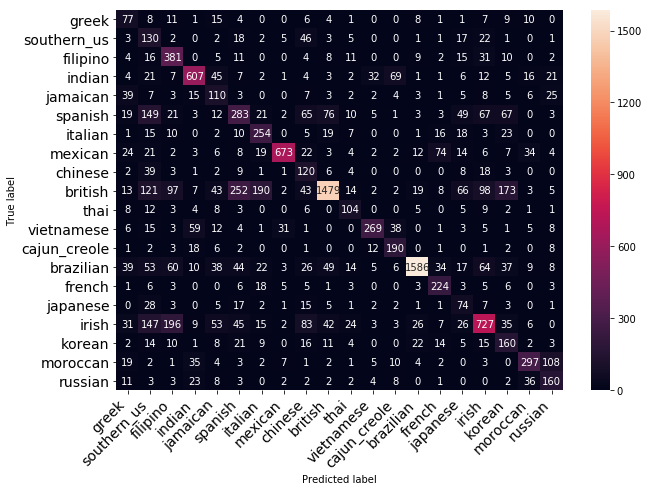

In [752]:
# cross validation

print('CONFUSION MATRIX: ')
print_confusion_matrix(confusion_matrix(y_test, mn_preds), train['cuisine'].unique());

In [753]:
print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, mn_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, mn_preds))

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

           0       0.25      0.47      0.33       163
           1       0.16      0.50      0.24       259
           2       0.46      0.75      0.57       509
           3       0.76      0.70      0.73       866
           4       0.29      0.44      0.35       248
           5       0.38      0.33      0.35       859
           6       0.46      0.66      0.54       384
           7       0.92      0.72      0.80       940
           8       0.25      0.55      0.35       217
           9       0.86      0.56      0.68      2637
          10       0.49      0.61      0.54       171
          11       0.78      0.58      0.67       462
          12       0.57      0.77      0.65       247
          13       0.93      0.75      0.83      2124
          14       0.57      0.77      0.65       292
          15       0.22      0.44      0.30       168
          16       0.66      0.49      0.56      1480

This is a weak prediction. An accuracy score of 60% is quite low, and we can see that some cuisines perform poorly on both precision and recall.  Let's try to further improve this by applying a grid search and tuning the hyperparameters.

#### Multinomical Naive Bayes with Grid Search

Let's try to further improve our MN model by tuning the parameters and applying a grid search.

The parameters  that we are most interesting in tuning are:

**alpha:** In this model, alpha refers to the pseudocount that we add to probabilities of bigrams to ensure everything is not zero. The only way for us to really find out the best alpha to set is by iterating over a range of options. 

**fit_prior:** This tells our model whether to learn class probabilities or not. We have balanced the data, so this could have an interesting impact on our model. 

**class_prior:** This tells the model the class_priors to use if fit_prior is True. We set these based on the distribution of cuisines in our original dataset. These prior probabilities were listed at the beginning of the Naive Bayes section. 

In [754]:
# Specifying the parameters we want to test

alpha = [0.0001, 0.001, 0.01, 0.1, 1]
fit_prior = [True, False]
class_prior = [None, [0.011741,
                      0.020214,
                      0.038870,
                      0.067205,
                      0.018982,
                      0.066526,
                      0.029542,
                      0.075502,
                      0.016770,
                      0.197063,
                      0.013225,
                      0.035777,
                      0.020868,
                      0.161865,
                      0.020642,
                      0.012294,
                      0.108614,
                      0.024865,
                      0.038694,
                      0.020742]]

In [755]:
# Building our parameter grid

mn_param_grid = {'alpha': alpha,
               'fit_prior': fit_prior,
               'class_prior': class_prior}

In [756]:
# Running the Grid Search, prioritising accuracy

mn_grid_search = GridSearchCV(MultinomialNB(), param_grid = mn_param_grid, scoring="accuracy")

In [757]:
mn2 = mn_grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 13728.38 seconds ---


In [758]:
print(mn2.best_score_)
print(mn2.best_params_)

0.562171052631579
{'alpha': 1, 'class_prior': None, 'fit_prior': True}


The grid search has told us that the defaul MultinomianlNB hyperparameters are in fact the best. This is clearly not the best algorithm for us to use, so let's move on to Random Forest. 

### Random Forest

Random Forest makes sense to try for this challenge because these models have the potential to identify specific relationships in the data. They do, of course, have the potential to overfit, so we will pay close attention to the cross-validation.

In [759]:
# import algorithm

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500) # We will immediately tune the model to a large number of estimators given dataset complexity and size

In [760]:
# train model

rfc.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 13837.94 seconds ---


In [761]:
# apply model to test set and get precitions

rfc_preds = rfc.predict(X_test)

CONFUSION MATRIX: 


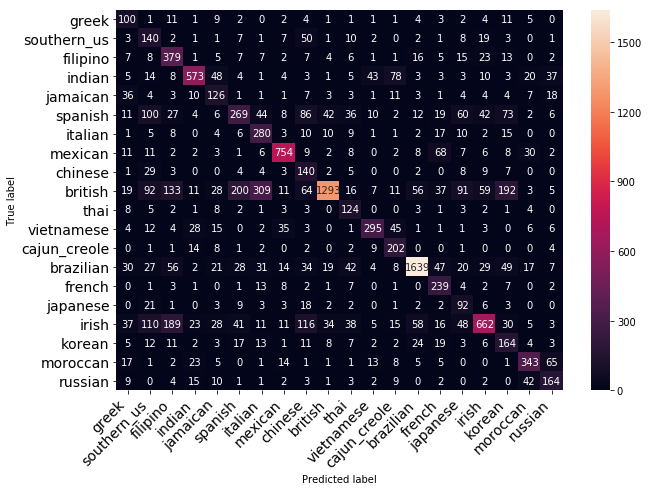

In [762]:
print('CONFUSION MATRIX: ')
print_confusion_matrix(confusion_matrix(y_test, rfc_preds), train['cuisine'].unique());

In [763]:
# cross-validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, rfc_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, rfc_preds))

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

           0       0.33      0.61      0.43       163
           1       0.24      0.54      0.33       259
           2       0.45      0.74      0.56       509
           3       0.80      0.66      0.73       866
           4       0.38      0.51      0.44       248
           5       0.45      0.31      0.37       859
           6       0.38      0.73      0.50       384
           7       0.85      0.80      0.83       940
           8       0.24      0.65      0.35       217
           9       0.91      0.49      0.64      2637
          10       0.38      0.73      0.50       171
          11       0.74      0.64      0.69       462
          12       0.51      0.82      0.63       247
          13       0.89      0.77      0.83      2124
          14       0.49      0.82      0.61       292
          15       0.24      0.55      0.34       168
          16       0.74      0.45      0.56      1480

This default random forest has performed very poorly. Let's tune the hyperparameters and see how we can improve. 

#### Random Forest with Grid Search

Let's try to further improve our Random Forest Classifier by tuning the parameters and applying a grid search.

We attempted running the Random Forest grid search with options for all (or almost all) of the possible hyperparameters. This was incredible computationally draining and took hours, so we instead reduced our interest range down to the below four hyperparameters. They provide stopping criteria (max depth and max features), trial different levels of randomness (through bootstrapping options) and also test based on different complexity levels (through n estimators).

**bootstrap:** If we turn off bootstrapping, all of the data is used to fit the model. This means there is no randomness between trees with respect to sampling. 

**max_depth:** The deeper the tree, the more splits it has and it captures more information about the data. We'll try a few different options here.

**max_features:** This is another stopping criteria that randomly subsample max features to choose the best one for the split. Auto means all the features are considered, while sqrt means the squareroot of the number of features is considered.

**n_estimators:** This tells the model how many unique decision trees to consider when building our model. We're going to try up to 500 to see how it impacts. 

In [764]:
# specifying the parameters we want to test

bootstrap = [True, False]
max_depth = [10, 30, 50, 70, None]
max_features = ['auto', 'sqrt']
n_estimators = [50,100,200,500]

In [765]:
# building parameter grid

rfc_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [766]:
# running the grid search

rfc_grid_search = GridSearchCV(RandomForestClassifier(), param_grid=rfc_param_grid, scoring="accuracy")

In [767]:
rfc2 = rfc_grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 22913.44 seconds ---


In [768]:
print(rfc2.best_score_)
print(rfc2.best_params_)

0.5967105263157895
{'bootstrap': False, 'max_depth': 70, 'max_features': 'auto', 'n_estimators': 500}


In [770]:
rfc_best = RandomForestClassifier(n_estimators = 500, bootstrap=False, max_depth=70, max_features='auto')

In [771]:
rfc_best.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [772]:
rfc_best_preds=rfc_best.predict(X_test)

CONFUSION MATRIX: 


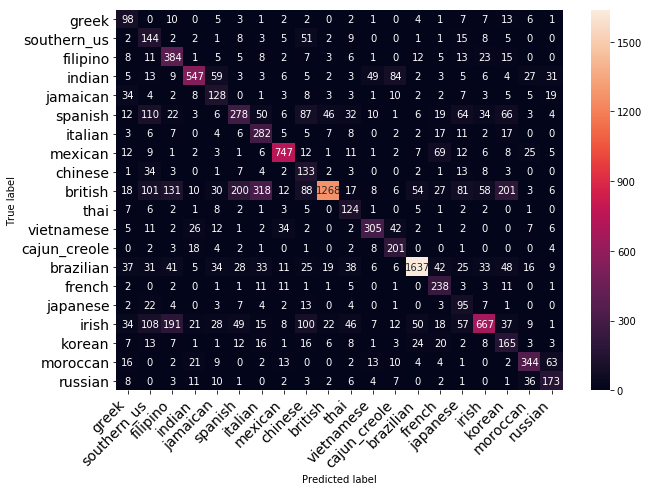

In [773]:
print('CONFUSION MATRIX: ')
print_confusion_matrix(confusion_matrix(y_test, rfc_best_preds), train['cuisine'].unique());

In [774]:
print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, rfc_best_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, rfc_best_preds))

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

           0       0.32      0.60      0.41       163
           1       0.23      0.56      0.33       259
           2       0.46      0.75      0.57       509
           3       0.81      0.63      0.71       866
           4       0.36      0.52      0.43       248
           5       0.45      0.32      0.38       859
           6       0.37      0.73      0.49       384
           7       0.85      0.79      0.82       940
           8       0.24      0.61      0.34       217
           9       0.92      0.48      0.63      2637
          10       0.37      0.73      0.49       171
          11       0.73      0.66      0.69       462
          12       0.52      0.81      0.63       247
          13       0.90      0.77      0.83      2124
          14       0.50      0.82      0.62       292
          15       0.23      0.57      0.32       168
          16       0.76      0.45      0.57      1480

In [ ]:
# evaluate the above

### Support Vector Machine

SVMs are the next logical algorithm to apply because they have been applied with success to text classification in countless other examples. An SVM helps us to find the decision boundary between two classes, that is as far from any point in the training data as possible. In the context of the What's Cooking challenge, The ability to apply kernel tricks will be particularly interesting, since our cuisines clearly are not linearly separable given the high levels of overlap of ingredients across cuisines. 

In [775]:
# import the algorithm

from sklearn.svm import SVC
svc = SVC()

In [776]:
# train the model

svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [779]:
# apply model to test set and get predictions

svc_preds = svc.predict(X_test)

CONFUSION MATRIX: 


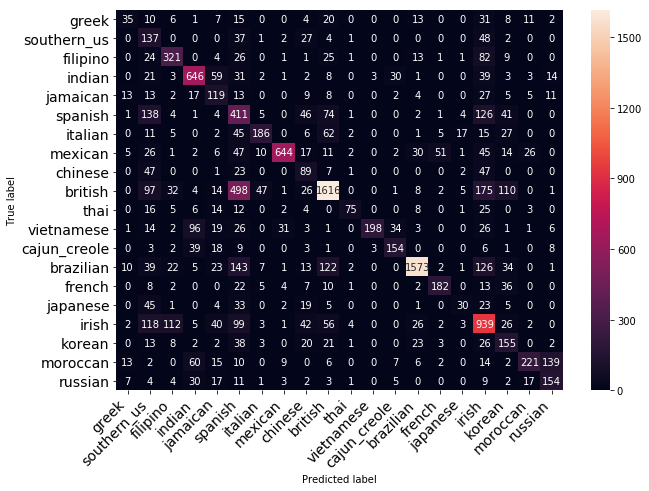

In [789]:
print('CONFUSION MATRIX: ')
print_confusion_matrix(confusion_matrix(y_test, svc_preds), train['cuisine'].unique());

In [780]:
# cross-validation

print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, svc_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, svc_preds))

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

           0       0.40      0.21      0.28       163
           1       0.17      0.53      0.26       259
           2       0.60      0.63      0.62       509
           3       0.71      0.75      0.73       866
           4       0.32      0.48      0.39       248
           5       0.27      0.48      0.34       859
           6       0.69      0.48      0.57       384
           7       0.92      0.69      0.78       940
           8       0.26      0.41      0.32       217
           9       0.78      0.61      0.69      2637
          10       0.82      0.44      0.57       171
          11       0.97      0.43      0.59       462
          12       0.66      0.62      0.64       247
          13       0.92      0.74      0.82      2124
          14       0.73      0.62      0.67       292
          15       0.46      0.18      0.26       168
          16       0.51      0.63      0.57      1480

Ok this one did really poorly. Let's run a grid search and see if we can improve.

#### SVC with Grid Search

Let's try to further improve our SVC by tuning the parameters and applying a grid search.

**kernel trick:** 

**C:** 



apply some kind of kernel trick! Let's try linear kernel because it is usually the best for text classification

https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/

then we just have to tune the C

The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. For very tiny values of C, you should get misclassified examples, often even if your training data is linearly separable.

If we 

In [782]:
# specifying the parameters we want to test

kernel = ['rbf', 'linear']
C = [0.01, 0.1, 1, 10, 100]

In [783]:
# building parameter grid

svc_param_grid = {'kernel': kernel,
               'C': C}

In [784]:
# running the grid search

svc_grid_search = GridSearchCV(SVC(), param_grid=svc_param_grid, scoring="accuracy")

In [785]:
svc2 = svc_grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 29492.86 seconds ---


In [786]:
print(svc2.best_score_)
print(svc2.best_params_)

0.5972039473684211
{'C': 100, 'kernel': 'rbf'}


In [790]:
svc_best = SVC(kernel = 'rbf', C = 100)

In [791]:
svc_best.fit(X_train, y_train)
print("--- %s seconds ---" % round(time.time() - start_time, 2))

--- 30829.72 seconds ---


In [794]:
svc_best_preds = svc_best.predict(X_test)

CONFUSION MATRIX: 


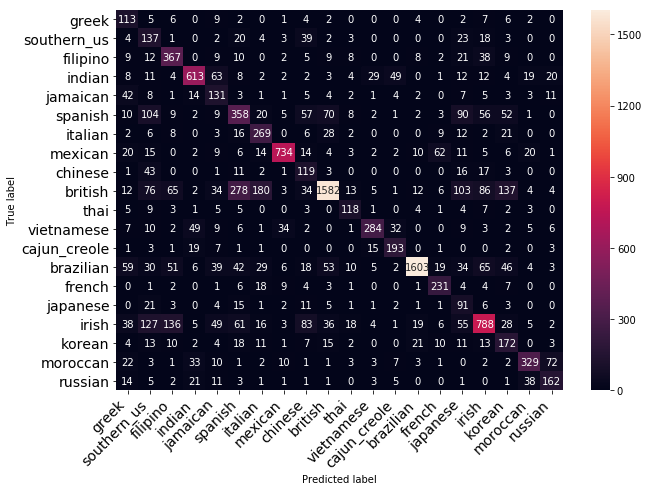

In [795]:
print('CONFUSION MATRIX: ')
print_confusion_matrix(confusion_matrix(y_test, svc_best_preds), train['cuisine'].unique());

In [796]:
print('CLASSIFICATION REPORT: ', '\n', '\n', classification_report(y_test, svc_best_preds))
print('\n')
print('ACCURACY SCORE: ', '\n', '\n', accuracy_score(y_test, svc_best_preds))

CLASSIFICATION REPORT:  
 
               precision    recall  f1-score   support

           0       0.30      0.69      0.42       163
           1       0.21      0.53      0.31       259
           2       0.55      0.72      0.62       509
           3       0.80      0.71      0.75       866
           4       0.32      0.53      0.40       248
           5       0.41      0.42      0.41       859
           6       0.47      0.70      0.56       384
           7       0.90      0.78      0.84       940
           8       0.29      0.55      0.38       217
           9       0.87      0.60      0.71      2637
          10       0.60      0.69      0.64       171
          11       0.80      0.61      0.70       462
          12       0.65      0.78      0.71       247
          13       0.95      0.75      0.84      2124
          14       0.65      0.79      0.72       292
          15       0.18      0.54      0.27       168
          16       0.69      0.53      0.60      1480

In [798]:
# evaluate the above

# Summarising the models

Here I propose creating some kind of visualization of accuracy vs. time taken for out attempted models. Then we can write a quick summary about learnings, blah blah.

In [ ]:
model = [log, log_best, 
          mn, mn_best, 
          rfc, rfc_best, 
          svc, svc_best]
accuracy = [0.6973854714536168, ]
times = [817.03, ]

model_summary = pd.DataFrame(np.column_stack([model, accuracy, time]), 
                               columns=['Model', 'Accuracy', 'Time'])

# Preparing our Kaggle submission

In [ ]:
test = pd.read_csv('test.json')

# apply the changes, eg. cleaning, vectorization, scaling, TruncatedSVD
# apply model and save predictions to csv